# II. Обучение моделей

### Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from src.config import PROCESSED_DATA_PATH, MODELS_PATH
from src.model_training import logreg_pipeline, rf_pipeline, lgb_model, xgb_model, get_param_grids
from src.utils import evaluate_metrics, save_model_results, display_results

from catboost import CatBoostClassifier, cv, Pool

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

Загрузим очищенные данные и посмотрим на них.

In [4]:
df = pd.read_parquet(PROCESSED_DATA_PATH / 'train_cleaned.parquet')
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtRatio_Flag,Total_Late_Payments,Income_per_Person,MonthlyIncome_log
0,1,0.766,45,2,0.803,9120.0,13,0,6,0,2.0,0,2,3040.0,9.118
1,0,0.957,40,0,0.122,2600.0,4,0,0,0,1.0,0,0,1300.0,7.864
2,0,0.658,38,1,0.085,3042.0,2,1,0,0,0.0,0,2,3042.0,8.021
3,0,0.234,30,0,0.036,3300.0,5,0,0,0,0.0,0,0,3300.0,8.102
4,0,0.907,49,1,0.025,63588.0,7,0,1,0,0.0,0,1,63588.0,11.060


In [5]:
y = df['SeriousDlqin2yrs']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: SeriousDlqin2yrs, dtype: int64

In [6]:
X = df.drop('SeriousDlqin2yrs', axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtRatio_Flag,Total_Late_Payments,Income_per_Person,MonthlyIncome_log
0,0.766,45,2,0.803,9120.0,13,0,6,0,2.0,0,2,3040.0,9.118
1,0.957,40,0,0.122,2600.0,4,0,0,0,1.0,0,0,1300.0,7.864
2,0.658,38,1,0.085,3042.0,2,1,0,0,0.0,0,2,3042.0,8.021
3,0.234,30,0,0.036,3300.0,5,0,0,0,0.0,0,0,3300.0,8.102
4,0.907,49,1,0.025,63588.0,7,0,1,0,0.0,0,1,63588.0,11.060


---

### Подготовка к валидации

Разделим данные на `X_train`, `y_train` (будем использовать для обучения) и `X_test`, `y_test` (отложенная выборка для финальной проверки). Используем `stratify=y` для сохранения пропорции классов.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Создадим объект для разделения данных на части с дисбалансом классов (стратифицированные fold'ы).

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Получим словарь всех сеток параметров для GridSearchCV.

In [9]:
all_params = get_param_grids()

---

### Обучение моделей

**Будем использовать следующие модели:**

1. Логистическая регрессия (Logistic Regression) — baseline.
2. Рандомный лес (Random Forest).
3. Градиентный бустинг (LightGBM, XGBoost, CatBoost).

#### Logistic Regression (логистическая регрессия)

In [10]:
logreg = GridSearchCV(
    estimator=logreg_pipeline(),
    param_grid=all_params['logreg'],
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

logreg.fit(X_train, y_train)

best_model = logreg.best_estimator_
best_params = logreg.best_params_

y_pred = best_model.predict_proba(X_test)[:, 1]

results = evaluate_metrics(y_test, y_pred)

print(f"ROC-AUC: {results['roc_auc']}")
print(f"Gini: {results['gini']}")

ROC-AUC: 0.8335
Gini: 0.6669


In [11]:
model_name = 'logreg_v1'
save_model_results(model_name, best_model, best_params, results)

#### Random Forest

In [12]:
rf = GridSearchCV(
    estimator=rf_pipeline(),
    param_grid=all_params['rf'],
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

rf.fit(X_train, y_train)

best_model = rf.best_estimator_
best_params = rf.best_params_

y_pred = best_model.predict_proba(X_test)[:, 1]

results = evaluate_metrics(y_test, y_pred)

print(f"ROC-AUC: {results['roc_auc']}")
print(f"Gini: {results['gini']}")

ROC-AUC: 0.8617
Gini: 0.7233


In [13]:
model_name = 'rf_v1'
save_model_results(model_name, best_model, best_params, results)

#### LightGBM

In [14]:
lgb = GridSearchCV(
    estimator=lgb_model(),
    param_grid=all_params['lgb'],
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
)

lgb.fit(X_train, y_train)

best_model = lgb.best_estimator_
best_params = lgb.best_params_

y_pred = best_model.predict_proba(X_test)[:, 1]

results = evaluate_metrics(y_test, y_pred)

print(f"ROC-AUC: {results['roc_auc']}")
print(f"Gini: {results['gini']}")

ROC-AUC: 0.8692
Gini: 0.7384


In [15]:
model_name = 'lgb_v1'
save_model_results(model_name, best_model, best_params, results)

#### XGBoost

In [16]:
xgb = GridSearchCV(
    estimator=xgb_model(),
    param_grid=all_params['xgb'],
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

xgb.fit(X_train, y_train)

best_model = xgb.best_estimator_
best_params = xgb.best_params_

y_pred = best_model.predict_proba(X_test)[:, 1]

results = evaluate_metrics(y_test, y_pred)

print(f"ROC-AUC: {results['roc_auc']}")
print(f"Gini: {results['gini']}")

ROC-AUC: 0.8688
Gini: 0.7376


In [17]:
model_name = 'xgb_v1'
save_model_results(model_name, best_model, best_params, results)

#### CatBoost

Для модели CatBoost не используется GridSearchCV из-за текущей несовместимости библиотеки с внутренними проверками scikit-learn. Параметры для модели подобраны вручную.

In [18]:
train_pool = Pool(X_train, y_train)

params = {
    'depth': 4,
    'learning_rate': 0.01,
    'iterations': 2000,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'random_seed': 42,
    'allow_writing_files': False,
    'silent': True
}

cv_res = cv(
    params=params,
    pool=train_pool,
    folds=skf,
    partition_random_seed=42,
    plot=False
)

mean_auc = cv_res['test-AUC-mean'].max()
print(f"Среднее по CV ROC-AUC: {mean_auc:.4f}")

catboost = CatBoostClassifier(
    **params
)

catboost.fit(X_train, y_train)

y_pred = catboost.predict_proba(X_test)[:, 1]

results = evaluate_metrics(y_test, y_pred)

print(f"ROC-AUC: {results['roc_auc']}")
print(f"Gini: {results['gini']}")

Training on fold [0/5]


D:\PycharmProjects\GiveMeSomeCredit\.venv\Lib\site-packages\sklearn\model_selection\_split.py:885: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



bestTest = 0.8706020602
bestIteration = 1937

Training on fold [1/5]

bestTest = 0.8627522549
bestIteration = 1603

Training on fold [2/5]

bestTest = 0.8635588789
bestIteration = 1838

Training on fold [3/5]

bestTest = 0.8623103258
bestIteration = 1470

Training on fold [4/5]

bestTest = 0.8689811575
bestIteration = 1999

Среднее по CV ROC-AUC: 0.8656
ROC-AUC: 0.8703
Gini: 0.7405


In [19]:
model_name = 'catboost_v1'
model = catboost

save_model_results(model_name, model, params, results)

---

### Сравнение моделей

In [20]:
pd.set_option('display.precision', 4)

final_table = display_results()
display(final_table)

,roc_auc,gini
model_name,,
catboost_v1,0.8703,0.7405
lgb_v1,0.8692,0.7384
xgb_v1,0.8688,0.7376
rf_v1,0.8617,0.7233
logreg_v1,0.8335,0.6669


**Выводы по результатам моделирования:**

- Модели градиентного бустинга показали лучшие результаты. Это подтверждает, что в данных о кредитовании присутствуют сложные нелинейные зависимости, которые бустинг улавливает лучше линейных моделей.
- Логистическая регрессия показала себя достойно, что говорит о хорошем качестве предобработки данных, однако она заметно уступает в точности разделения классов.
- Использование CatBoost вместо логистической регрессии позволяет увеличить индекс Джини на ~7% (с 0.6669 до 0.7405), что существенно минимизирует кредитные убытки.

---

### Интерпретация Logistic Regression

Для интерпретации модели извлечем финальную логистическую регрессию `best_estimator_` и её коэффициенты после всех преобразований пайплайна, включая заполнение пропусков и стандартизацию признаков.

In [21]:
best_logreg = logreg.best_estimator_
best_logreg

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If 

In [22]:
logreg_model = best_logreg.named_steps['model']
coefs = logreg_model.coef_[0]
coefs

array([ 0.84903203, -0.2717611 ,  1.30471569,  0.35437471, -0.38501778,
        0.13361102,  0.98650011,  0.09047943, -0.72418915,  0.0732873 ,
       -0.38584556,  0.52735587,  0.15380415,  0.02173196])

Извлечем названия признаков из тренировочных данных в том порядке, в котором они были при обучении модели.

In [23]:
feature_names = X_train.columns
feature_names

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'DebtRatio_Flag', 'Total_Late_Payments',
       'Income_per_Person', 'MonthlyIncome_log'],
      dtype='object')

Создадим таблицу влияния признаков.

Для удобства бизнес-интерпретации коэффициенты будут переведены в odds ratio, показывающие, во сколько раз изменяются шансы дефолта.

In [24]:
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs
})

coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df['risk_change_in_percent'] = (coef_df['odds_ratio'] - 1) * 100

coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
coef_df

,feature,coef,odds_ratio,abs_coef,risk_change_in_percent
0,NumberOfTime30-59DaysPastDueNotWorse,1.3047,3.6866,1.3047,268.6641
1,NumberOfTimes90DaysLate,0.9865,2.6818,0.9865,168.1832
2,RevolvingUtilizationOfUnsecuredLines,0.8490,2.3374,0.8490,133.7383
3,Total_Late_Payments,0.5274,1.6944,0.5274,69.4446
4,DebtRatio,0.3544,1.4253,0.3544,42.5289
5,Income_per_Person,0.1538,1.1663,0.1538,16.6262
6,NumberOfOpenCreditLinesAndLoans,0.1336,1.1429,0.1336,14.2948
7,NumberRealEstateLoansOrLines,0.0905,1.0947,0.0905,9.4699
8,NumberOfDependents,0.0733,1.0760,0.0733,7.6040
9,MonthlyIncome_log,0.0217,1.0220,0.0217,2.1970


На основе таблицы можно выделить предикторы дефолта и защитные факторы.

**Ключевые факторы риска:**
1. `NumberOfTime30-59DaysPastDueNotWorse` и `NumberOfTimes90DaysLate` имеют самые высокие веса (coef). Увеличение показателей на одно стандартное отклонение увеличивает шансы дефолта на 268% и на 168% соответственно. История платежей является критическим индикатором надежности заемщика.
2. `RevolvingUtilizationOfUnsecuredLines` — рост использования лимита на одно стандартное отклонение повышает риск дефолта на 133%. Высокая закредитованность сигнализирует о финансовых трудностях клиента.
3. `Total_Late_Payments` — суммарное количество просрочек повышает риск дефолта, подтверждая, что платёжная история — ключевой драйвер риска.
4. `DebtRatio` — долговая нагрузка имеет значимый положительный коэффициент, увеличивая риск на 42%.

**Защитные факторы:**
1. `MonthlyIncome` — высокий уровень дохода снижает риск на 32%. Стоит заметить, что логарифмированный доход имеет меньший вес, что говорит о важности абсолютных значений заработка.
2. `age` — с увеличением возраста на 1 стандартное отклонение риск дефолта снижается на 23%. Более зрелые клиенты обладают более стабильным финансовым положением.
3. `DebtRatio_Flag` — отрицательный коэффициент после добавления других факторов может свидетельствовать о перекрытии информации с базовым DebtRatio.
4. Признак `NumberOfTime60-89DaysPastDueNotWorse` получил отрицательный коэффициент (-0.72), что противоречит бизнес-логике (просрочка не может снижать риск). Отрицательное влияние может указывать на корреляцию с другими признаками просрочек (мультиколлинеарность) и эффект регуляризации модели.

Новые признаки `Total_Late_Payments` и `Income_per_Person` подтвердили значимую связь.

Визуализируем результат (коэффициенты модели логистической регрессии).

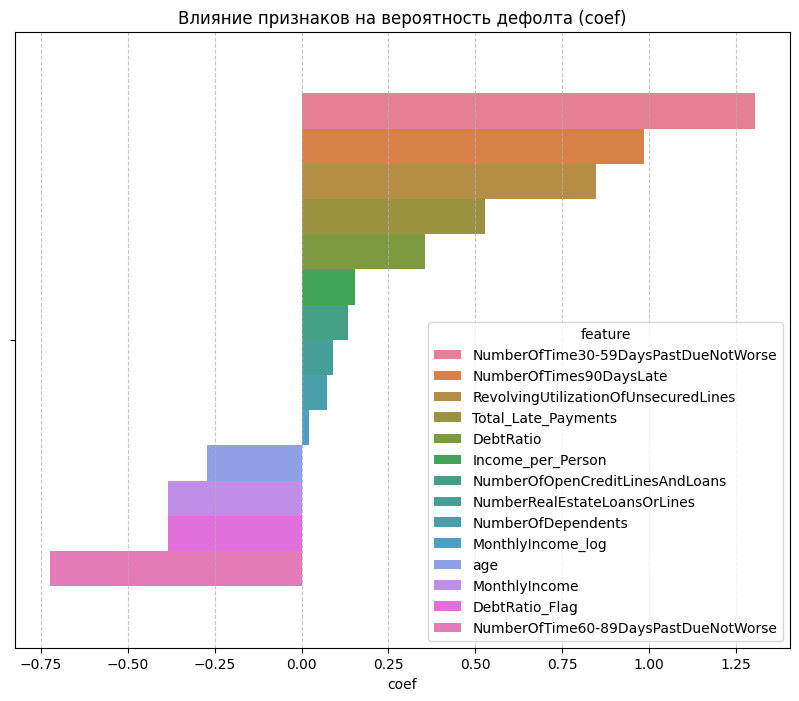

In [25]:
plt.figure(figsize=(10, 8))
sns.barplot(data=coef_df, x='coef', hue='feature')
plt.title('Влияние признаков на вероятность дефолта (coef)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

---